In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import seaborn as sns
import re
import nltk
import torch
from datetime import datetime, timedelta
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Reshape, Dense, Dropout, Input, Embedding, LSTM
from allennlp.modules.elmo import Elmo, batch_to_ids
from transformers import AutoTokenizer, AutoModel
from keras_self_attention import SeqSelfAttention
from sklearn import svm
from sklearn.model_selection import GridSearchCV

2024-01-30 11:33:00.146273: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/katarina_glorija/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
conversation_df = pd.read_excel('data/Conversations_without_frustrationTutor.xlsx')
conversation_df.head()

,Id,LearnerId,DateTime,Konverzacije,Emocija,Aspekt,Obrazloženje
0,1093,-9991,2023-05-03 14:26:41.179435+02,"{""Zdravo! Kako se osećaš povodom učenja u ovom...",Neutralno,Lekcija,NaN
1,705,271,2023-05-02 12:55:06.690703+02,"{""Zdravo! Kako se osećaš povodom učenja u ovom...",Angažovanost,Zadaci,NaN
2,1083,-9991,2023-05-03 13:44:39.768422+02,"{""Zdravo! Kako se osećaš povodom učenja u ovom...",Neutralno,Lekcija,NaN
3,656,199,2023-05-01 22:48:41.422144+02,"{""Zdravo! Kako se osećaš povodom učenja u ovom...",Nezainteresovanost,Tutor,NaN
4,1149,271,2023-05-03 18:07:40.166059+02,"{""Zdravo! Kako se osećaš povodom učenja u ovom...",Zbunjenost,Instrukcioni materijali,NaN


In [3]:
temp_dict_emocija = {
    'Angažovanost' : 1,
    'Neutralno' : 1,
    'Frustracija' : 2,
    'Zbunjenost' : 3,
    'Nezainteresovanost' : 4,
    'Umor' : 5,
}

temp_dict_aspekt = {
    'Lekcija' : 1,
    'Zadaci' : 2,
    'Instrukcioni materijali' : 3,
    'Tutor' : 4,
    'Projekat' : 5,
    'Drugi aspekt' : 6,
}

conversation_df_copy = conversation_df.copy()
conversation_df_copy['Emocija'] = conversation_df_copy['Emocija'].map(temp_dict_emocija)
conversation_df_copy['Aspekt'] = conversation_df_copy['Aspekt'].map(temp_dict_aspekt)

In [12]:
X = pd.read_csv('embeddings/bert_embeddings_without_preprocessing_sentences.csv')
y = conversation_df_copy['Emocija']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [13]:
clf = GaussianNB()
params = {'priors': [None, [0.5, 0.5]], 'var_smoothing': [1e-9, 1e-8, 1e-7]}
grid_search = GridSearchCV(clf, params, cv=5, scoring='f1_weighted')
grid_search.fit(X_train, y_train)

# Make predictions
y_pred = grid_search.predict(X_test)

# Evaluate the model
accuracy = f1_score(y_test, y_pred, average='weighted')
print("Accuracy:", accuracy)

Accuracy: 0.6258360058757946


/Users/katarina_glorija/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/katarina_glorija/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/katarina_glorija/miniconda3/lib/python3.9/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/katarina_glorija/miniconda3/lib/python3.9/site-packages/sklearn/naive_bayes.py", line 263, in 

In [14]:
params = {'n_estimators': [50, 100, 150], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}
rf_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf_model, params, cv=5, scoring='f1_weighted')

# Step 3: Train the Random Forest model on the training data
grid_search.fit(X_train, y_train)

# Step 4: Make predictions on the testing data
y_pred = grid_search.predict(X_test)

f1 = f1_score(y_test, y_pred, average = 'weighted')
print("F1 Score:", f1)

F1 Score: 0.6792377779288774


In [15]:
clf = svm.SVC()
params = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
grid_search = GridSearchCV(clf, params, cv=5, scoring='f1_weighted')
# Step 3: Train the SVM model on the training data
grid_search.fit(X_train, y_train)
# Step 4: Make predictions on the testing data
y_pred = grid_search.predict(X_test)

f1 = f1_score(y_test, y_pred, average = 'weighted')
print("F1 Score:", f1)

F1 Score: 0.7496344794407418


In [18]:
error_mask = y_test != y_pred

# Get the indices where errors occur
error_indices = np.where(error_mask)[0]

# Print or analyze the errors
for idx in error_indices:
    print(f"Index {idx}: True Label - {y_test.iloc[idx]}, Predicted Label - {y_pred[idx]}")
    matching_index = (X == X_test.iloc[idx]).all(axis=1).idxmax()
    print(conversation_df_copy['Konverzacije'][matching_index])

Index 0: True Label - 4, Predicted Label - 1
{"Zdravo! Kako se osećaš povodom učenja u ovom trenutku?
 -Samo zelim da zavrsim
 
 -Možeš li mi reći koji faktori su uticali na tvoje raspoloženje?
 -I dalje me mrzi, ali mislim da ova pitanja previse cesto izlaze, ne menja se raspolozenje oko ucenja svakih 10 minuta. Kako sam se osecao kad sam krenuo i dalje se tako osecam
 -Hvala na povratnoj informaciji! Vremenom ću bolje naučiti da pomažem učenicima."}
Index 7: True Label - 2, Predicted Label - 1
{"Zdravo! Kako se osećaš povodom učenja u ovom trenutku?
 -jos nervoznije nego prosl
 i put
 -Možeš li mi reći koji faktori su uticali na tvoje raspoloženje?
 -pokusavam da odradim ovu lekciju a ti me ometas i ne mogu da se skoncetrisem jer svakih ne znam ni sam koliko minuta dolazis i pitas me jedno te isto pitanje. Vise mi odmazes nego sto mi pomazes svojim zapitkivanjem
 
 -Hvala na povratnoj informaciji! Vremenom ću bolje naučiti da pomažem učenicima."}
Index 9: True Label - 2, Predicted La

In [19]:
from sklearn.metrics import precision_recall_fscore_support

# Assuming y_true and y_pred are your true and predicted labels
# Each element in y_true and y_pred should be an integer representing the class label

# Calculate precision, recall, and F1 score for each label
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average=None)

# Print or use the results as needed
for label, p, r, f1 in zip(range(len(precision)), precision, recall, f1_score):
    print(f"Label {label}: Precision={p:.4f}, Recall={r:.4f}, F1 Score={f1:.4f}")

Label 0: Precision=0.8740, Recall=0.9024, F1 Score=0.8880
Label 1: Precision=0.5000, Recall=0.4483, F1 Score=0.4727
Label 2: Precision=0.2500, Recall=0.1667, F1 Score=0.2000
Label 3: Precision=0.3333, Recall=0.2727, F1 Score=0.3000
Label 4: Precision=0.5714, Recall=0.6667, F1 Score=0.6154


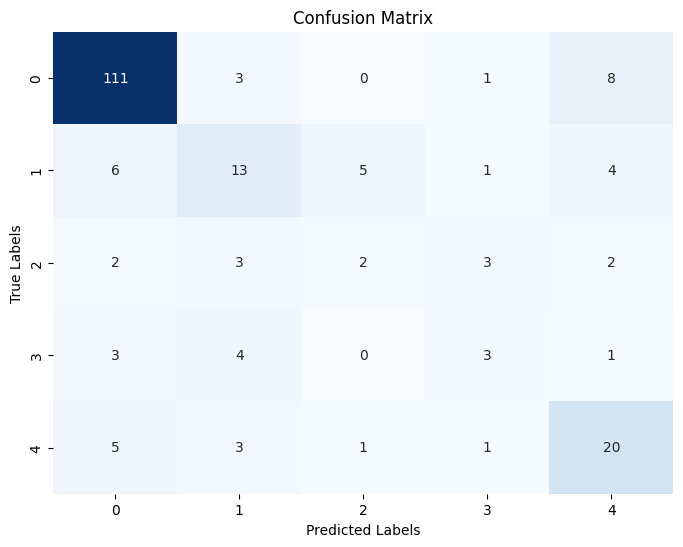

Overall Accuracy: 0.7268


In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Assuming y_true and y_pred are your true and predicted labels
# Each element in y_true and y_pred should be an integer representing the class label

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

# Calculate overall accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Overall Accuracy: {accuracy:.4f}')

In [23]:
def extract_second_sentence(conversation):
    # Split the conversation into sentences
    start_index = conversation.find('-') + 1
    end_index = conversation.find('-', start_index)
    second_sentence = conversation[start_index:end_index].strip() if end_index != -1 else None

    return second_sentence

# Apply the function to your dataset
conversation_df['Prvi_odgovor'] = conversation_df['Konverzacije'].apply(extract_second_sentence)

In [24]:
def preprocess_text(text):
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Convert to lowercase
    text = text.lower()

    # Remove stopwords
    stop_words = set(stopwords.words('serbian'))
    words = nltk.word_tokenize(text)
    words = [word for word in words if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    return ' '.join(words)

In [25]:
# Example text data
texts = conversation_df['Prvi_odgovor']
preprocessed_text = [preprocess_text(sentence) for sentence in texts]

# Example labels
labels = conversation_df_copy['Emocija']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(preprocessed_text, labels, test_size=0.2, stratify=labels)

# Use TfidfVectorizer to transform text data
vectorizer = TfidfVectorizer()
X_train_transformed = vectorizer.fit_transform(X_train)
X_test_transformed = vectorizer.transform(X_test)

In [7]:
embedding_size = X_train_transformed.shape[1]
feature_names = vectorizer.get_feature_names_out()

# Get the size (number of features) of the TF-IDF dictionary
tfidf_dict_size = len(feature_names)

print("TF-IDF dictionary size:", tfidf_dict_size)

print("TF-IDF embedding size:", embedding_size)

TF-IDF dictionary size: 525
TF-IDF embedding size: 525


In [26]:
# Train MultinomialNB
clf = MultinomialNB()
params = {'alpha': [0.1, 0.5, 1.0, 2.0]}
grid_search = GridSearchCV(clf, params, cv=5, scoring='f1_weighted')
grid_search.fit(X_train_transformed, y_train)

# Make predictions
y_pred = grid_search.predict(X_test_transformed)

# Calculate F1 score
f1 = f1_score(y_test, y_pred, average = 'micro')
print("F1 Score:", f1)

F1 Score: 0.7539267015706806


In [43]:
error_mask = y_test != y_pred

# Get the indices where errors occur
error_indices = np.where(error_mask)[0]

# Print or analyze the errors
for idx in error_indices:
    print(f"Index {idx}: True Label - {y_test.iloc[idx]}, Predicted Label - {y_pred[idx]}")
    matching_index = preprocessed_text.index(X_test[idx])
    print(conversation_df_copy['Konverzacije'][matching_index])

Index 0: True Label - 4, Predicted Label - 1
{"Zdravo! Kako se osećaš povodom učenja u ovom trenutku?
 -Samo zelim da zavrsim
 
 -Možeš li mi reći koji faktori su uticali na tvoje raspoloženje?
 -I dalje me mrzi, ali mislim da ova pitanja previse cesto izlaze, ne menja se raspolozenje oko ucenja svakih 10 minuta. Kako sam se osecao kad sam krenuo i dalje se tako osecam
 -Hvala na povratnoj informaciji! Vremenom ću bolje naučiti da pomažem učenicima."}
Index 13: True Label - 2, Predicted Label - 3
{"Zdravo! Kako se osećaš povodom učenja u ovom trenutku?
 -Zbunjeno
 -Možeš li mi reći koji faktori su uticali na tvoje raspoloženje?
 -Apstraktna lekcija sa puno novih termina
 -Hvala na povratnoj informaciji! Vremenom ću bolje naučiti da pomažem učenicima."}
Index 14: True Label - 5, Predicted Label - 2
{"Zdravo! Kako se osećaš povodom učenja u ovom trenutku?
 - Lose
 - Možeš li mi reći šta je uticalo na tvoje raspoloženje?
 -ispit
 -Hvala na povratnoj informaciji! Vremenom ću bolje naučiti 

In [8]:
from sklearn.metrics import precision_recall_fscore_support

# Assuming y_true and y_pred are your true and predicted labels
# Each element in y_true and y_pred should be an integer representing the class label

# Calculate precision, recall, and F1 score for each label
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average=None)

# Print or use the results as needed
for label, p, r, f1 in zip(range(len(precision)), precision, recall, f1_score):
    print(f"Label {label}: Precision={p:.4f}, Recall={r:.4f}, F1 Score={f1:.4f}")

Label 0: Precision=0.8451, Recall=0.9756, F1 Score=0.9057
Label 1: Precision=0.3571, Recall=0.3333, F1 Score=0.3448
Label 2: Precision=0.6667, Recall=0.3333, F1 Score=0.4444
Label 3: Precision=0.0000, Recall=0.0000, F1 Score=0.0000
Label 4: Precision=0.6786, Recall=0.6333, F1 Score=0.6552


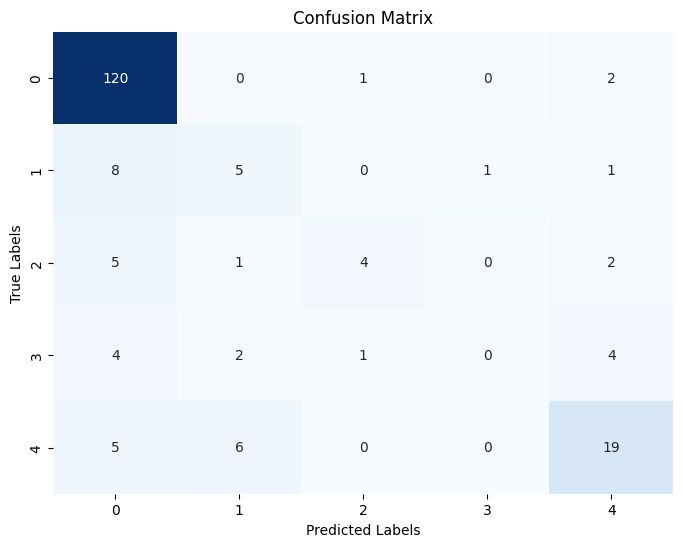

Overall Accuracy: 0.7749


In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Assuming y_true and y_pred are your true and predicted labels
# Each element in y_true and y_pred should be an integer representing the class label

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

# Calculate overall accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Overall Accuracy: {accuracy:.4f}')

In [27]:
params = {'n_estimators': [50, 100, 150], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}
rf_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf_model, params, cv=5, scoring='f1_weighted')
grid_search.fit(X_train_transformed, y_train)

# Step 4: Make predictions on the testing data
y_pred = grid_search.predict(X_test_transformed)

f1 = f1_score(y_test, y_pred, average = 'micro')
print("F1 Score:", f1)

F1 Score: 0.7486910994764399


In [28]:
clf = svm.SVC()
params = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
grid_search = GridSearchCV(clf, params, cv=5, scoring='f1_weighted')
# Step 3: Train the SVM model on the training data
grid_search.fit(X_train_transformed, y_train)

# Step 4: Make predictions on the testing data
y_pred = grid_search.predict(X_test_transformed)

f1 = f1_score(y_test, y_pred, average = 'micro')
print("F1 Score:", f1)

F1 Score: 0.774869109947644
